<a href="https://colab.research.google.com/github/Sachin20010517/pneumonet-cnn-classifier/blob/main/PneumoNet_Complete_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: **Rammini Sachin Ayeshmantha De Silva Dharmawickrama**









UoW id: **w1953261**

# ***PneumoNet: Deep Learning for Pneumonia Detection***

<h2>Part A – Application area review.</h2>
<h4><u>Literature Review: AI Applications in Medical Image Analysis for Pneumonia Detection </u></h4>
<br/>
<h4><b>Introduction</b></h4>
<br/>
<p style="text-align:justify">
Artificial intelligence (AI) has revolutionised medical diagnostics, particularly in radiology where deep learning algorithms demonstrate remarkable capabilities in detecting diseases from medical images. Pneumonia, a leading cause of mortality globally with approximately 2.5 million deaths annually (World Health Organization, 2023), presents a significant diagnostic challenge, particularly in resource-constrained settings. This literature review explores how AI, specifically deep learning techniques, has been applied to pneumonia detection from chest X-rays, examining the evolution of approaches, their effectiveness, and clinical implications.
<br/><br/>
<h4><b>Evolution of AI in Medical Image Analysis</b></h4>
<br/>
<p style="text-align:justify">
The application of AI to medical imaging has progressed significantly since the introduction of computer-aided diagnosis (CAD) systems in the 1980s. Traditional machine learning approaches relied heavily on manual feature engineering, requiring domain experts to define relevant image characteristics (Suzuki, 2017). However, the advent of deep learning, particularly Convolutional Neural Networks (CNNs), has transformed medical image analysis by enabling automatic feature extraction directly from raw image data (Litjens et al., 2017).
<br/><br/>
CNNs have become the predominant architecture for medical image classification due to their ability to learn hierarchical representations of visual patterns. The breakthrough work by Krizhevsky, Sutskever and Hinton (2012) with AlexNet demonstrated that deep CNNs could achieve superior performance in image recognition tasks, paving the way for their application in medical domains. Subsequent architectures such as ResNet (He et al., 2016), DenseNet (Huang et al., 2017), and EfficientNet (Tan and Le, 2019) have further enhanced classification accuracy whilst addressing challenges such as vanishing gradients and computational efficiency.
<br/><br/>


Import Libraries

In [18]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

In [19]:
print(tf.__version__)

2.19.0


In [20]:
np.random.seed(42)
tf.random.set_seed(42)

Data Loading

In [21]:
#Mount Google Drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/FYP/pneumonia-Xray-dataset.zip" -d /content/



Streaming output truncated to the last 5000 lines.
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0439-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0440-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0441-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0442-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0444-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0445-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0446-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0447-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MAC

In [22]:
#Set my dataset paths
main_path = "/content/pneumonia-Xray-dataset/chest_xray"
os.listdir(main_path)

['train', '__MACOSX', 'val', 'chest_xray', 'test']

In [23]:
train_dir = os.path.join(main_path, 'train')
val_dir = os.path.join(main_path, 'val')
test_dir = os.path.join(main_path, 'test')

In [24]:
def count_file(dir=None, labels=None):
    for label in labels:
        num_data = len(os.listdir(os.path.join(dir, label)))
        print(f'number of {label} : {num_data}')

labels = ['PNEUMONIA', 'NORMAL']

print('Train Set: \n' + '='*50)
count_file(train_dir, labels)

print('\nValidation Set: \n' + '='*50)
count_file(val_dir, labels)

print('\nTest Set: \n' + '='*50)
count_file(test_dir, labels)


Train Set: 
number of PNEUMONIA : 3875
number of NORMAL : 1341

Validation Set: 
number of PNEUMONIA : 8
number of NORMAL : 8

Test Set: 
number of PNEUMONIA : 390
number of NORMAL : 234


Notice that there are significantly more images classified as pneumonia than normal. This indicates that our dataset is imbalanced. We will address this imbalance later in this notebook.

In [25]:
def get_file_sizes(directory):
    """Collect the size (in KB) of every file within a directory tree."""

    sizes = []

    # Traverse all subdirectories and files
    for root, _, files in os.walk(directory):
        for filename in files:
            path = os.path.join(root, filename)
            size_kb = os.path.getsize(path) / 1024  # convert bytes to KB
            sizes.append({
                'file': path,
                'size_kb': round(size_kb, 3)
            })

    return sizes

In [26]:
get_file_sizes(train_dir)[:5]

[{'file': '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person867_bacteria_2789.jpeg',
  'size_kb': 61.81},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person502_bacteria_2123.jpeg',
  'size_kb': 87.954},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person330_virus_683.jpeg',
  'size_kb': 84.846},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person890_bacteria_2814.jpeg',
  'size_kb': 49.426},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person1284_bacteria_3247.jpeg',
  'size_kb': 120.225}]

Next, we will create a dataframe to make it easier to analyze the image sizes and the class distribution.

In [27]:
def create_dataframe(path=None, labels=None):
    """
    Build a dataframe containing file paths and sizes (in KB)
    for all images within the specified class folders.
    """

    records = []

    for label in labels:
        class_dir = os.path.join(path, label)
        sizes = get_file_sizes(class_dir)
        records.extend(sizes)

    return pd.DataFrame(records)

In [28]:
# Create dataframes for each dataset split
train_df = create_dataframe(train_dir, labels)
test_df  = create_dataframe(test_dir, labels)
val_df   = create_dataframe(val_dir, labels)

# Display the shape of each dataframe
print("Train set shape:", train_df.shape)
print("Test set shape:",  test_df.shape)
print("Validation set shape:", val_df.shape)


Train set shape: (5216, 2)
Test set shape: (624, 2)
Validation set shape: (16, 2)


In [29]:
train_df.head(3)

,file,size_kb
0,/content/pneumonia-Xray-dataset/chest_xray/tra...,61.810
1,/content/pneumonia-Xray-dataset/chest_xray/tra...,87.954
2,/content/pneumonia-Xray-dataset/chest_xray/tra...,84.846


In [30]:
def extract_label(file_path):
    """
    Determine the class label based on the file path.
    Returns 'pneumonia', 'normal', or 'unknown' if no match is found.
    """
    if "PNEUMONIA" in file_path:
        return "pneumonia"
    elif "NORMAL" in file_path:
        return "normal"
    else:
        return "unknown"


# Dictionary mapping dataset splits to their corresponding dataframes
dict_dir_df = {
    "train": train_df,
    "val":   val_df,
    "test":  test_df
}


In [31]:
# Assign class labels to each dataframe based on file paths
for df in dict_dir_df.values():
    df["label"] = df["file"].apply(extract_label)

In [32]:
train_df.sample(3)

,file,size_kb,label
1897,/content/pneumonia-Xray-dataset/chest_xray/tra...,162.789,pneumonia
877,/content/pneumonia-Xray-dataset/chest_xray/tra...,68.940,pneumonia
4503,/content/pneumonia-Xray-dataset/chest_xray/tra...,579.882,normal


In [33]:
def get_image_dimensions(file_path):
    """
    Return the (width, height) of an image.
    If the image cannot be opened, return (0, 0).
    """
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)  # Default value if the image cannot be read


In [34]:
# Add image dimensions (width, height) to each dataframe
for split_name, df in dict_dir_df.items():
    df["dimensions"] = df["file"].apply(get_image_dimensions)

In [35]:
# Filter rows where the 'dimensions' tuple has a length of at least 3
for split_name, df in dict_dir_df.items():
    filtered_df = df[df["dimensions"].apply(lambda x: len(x) >= 3)]
    print(f"{split_name}: {filtered_df.shape[0]}")

train: 0
val: 0
test: 0


In [36]:
train_df.sample(3)

,file,size_kb,label,dimensions
318,/content/pneumonia-Xray-dataset/chest_xray/tra...,46.023,pneumonia,"(896, 648)"
4221,/content/pneumonia-Xray-dataset/chest_xray/tra...,1999.234,normal,"(2553, 2305)"
5028,/content/pneumonia-Xray-dataset/chest_xray/tra...,190.960,normal,"(1392, 1232)"


We can observe that the images in this dataset contain only two dimensions—height and width. This indicates that the images can be treated as grayscale.

In [37]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 4)
shape of test_dir (624, 4)
shape of val_dir (16, 4)


The validation set contains only 16 images, which is too small for reliable evaluation. Therefore, we will combine all images from the train, validation, and test folders, then perform a new split using a 70:15:15 ratio — allocating 70% for training, 15% for validation, and 15% for testing.

In [38]:
merged_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
merged_df.shape

(5856, 4)

In [39]:
# First split: 70% train, 30% temp (test + val)
train_df, test_df_full = train_test_split(
    merged_df,
    test_size=0.3,
    stratify=merged_df['label'],
    random_state=42
)

# Second split: split the 30% into 15% test and 15% val
test_df, val_df = train_test_split(
    test_df_full,
    test_size=0.5,
    stratify=test_df_full['label'],
    random_state=42
)


In [40]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 4)
(878, 4)
(879, 4)


Exploratory Data Analysis (EDA)

In [41]:
# Create a subplot layout with two panels: one for a bar chart and one for a pie chart
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'xy'}, {'type': 'domain'}]]
)

# --- Bar Chart ---
bar_chart = go.Figure(
    go.Bar(
        x=train_df['label'].value_counts().index,
        y=train_df['label'].value_counts().values,
        marker_color=['#fe346e', '#2c003e']
    )
)
fig.add_trace(bar_chart['data'][0], row=1, col=1)

# --- Pie Chart ---
pie_chart = go.Figure(
    go.Pie(
        labels=train_df['label'].value_counts().index,
        values=train_df['label'].value_counts().values,
        marker=dict(
            colors=['#fe346e', '#2c003e'],
            line=dict(color='gray', width=3)
        ),
        pull=[0.05, 0]  # Exploded slice effect
    )
)
fig.add_trace(pie_chart['data'][0], row=1, col=2)

# --- Layout Configuration ---
fig.update_layout(
    showlegend=False,  # Hide legend (optional)
    title='Distribution of Diagnoses in the Training Set',
    title_x=0.5,       # Center the title
    shapes=[
        dict(
            type='line',
            x0=0.5, y0=0,
            x1=0.5, y1=1,
            line=dict(color='black', width=2)
        )
    ]
)

fig.show()


In [42]:
# Calculate the average image height and width
height_mean = train_df['dimensions'].apply(lambda x: x[0]).mean()
width_mean = train_df['dimensions'].apply(lambda x: x[1]).mean()

print(f"The average image height is {height_mean:.2f} pixels")
print(f"The average image width is {width_mean:.2f} pixels")


The average image height is 1324.03 pixels
The average image width is 968.02 pixels


In [43]:
# Display the minimum file size for each dataset split
dict_dir_df = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

for split_name, df in dict_dir_df.items():
    print(f"Minimum file size in the {split_name} set: {df['size_kb'].min()} KB")


Minimum file size in the train set: 5.627 KB
Minimum file size in the val set: 6.84 KB
Minimum file size in the test set: 5.313 KB


Images with very small file sizes are more likely to produce inaccurate predictions, especially when the files have been compressed and important visual details may have been lost.”

In [44]:
# Display the maximum file size for each dataset split
for split_name, df in dict_dir_df.items():
    print(f"Maximum file size in the {split_name} set: {df['size_kb'].max()} KB")


Maximum file size in the train set: 2278.475 KB
Maximum file size in the val set: 1804.62 KB
Maximum file size in the test set: 2357.756 KB


In [45]:
# Extract image height and width values from the "dimensions" column
heights, widths = zip(*train_df['dimensions'])

# Create a boxplot comparing height and width distributions
fig = px.box(
    x=['Height'] * len(heights) + ['Width'] * len(widths),
    y=list(heights) + list(widths),
    labels={'x': 'Dimension Type', 'y': 'Pixels'},
    points='outliers',
    title="Boxplot of Image Dimensions (Height and Width)"
)

# Customize marker appearance
fig.update_traces(
    marker_color='#fe346e',
    marker_line_color='#fe346e',
    marker_line_width=1,
    opacity=1
)

fig.show()


In [46]:
def plot_images(image_paths, label, nrows=2, ncols=5):
    # Create a grid of subplots for displaying sample images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))
    num_images = nrows * ncols

    for i in range(num_images):
        img = Image.open(image_paths[i])
        row_idx, col_idx = divmod(i, ncols)

        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f"{label}\nShape: {img.size}")

    plt.show()

# Retrieve file paths for each class
pneumonia_paths = train_df.query("label == 'pneumonia'")['file'].values
normal_paths    = train_df.query("label == 'normal'")['file'].values


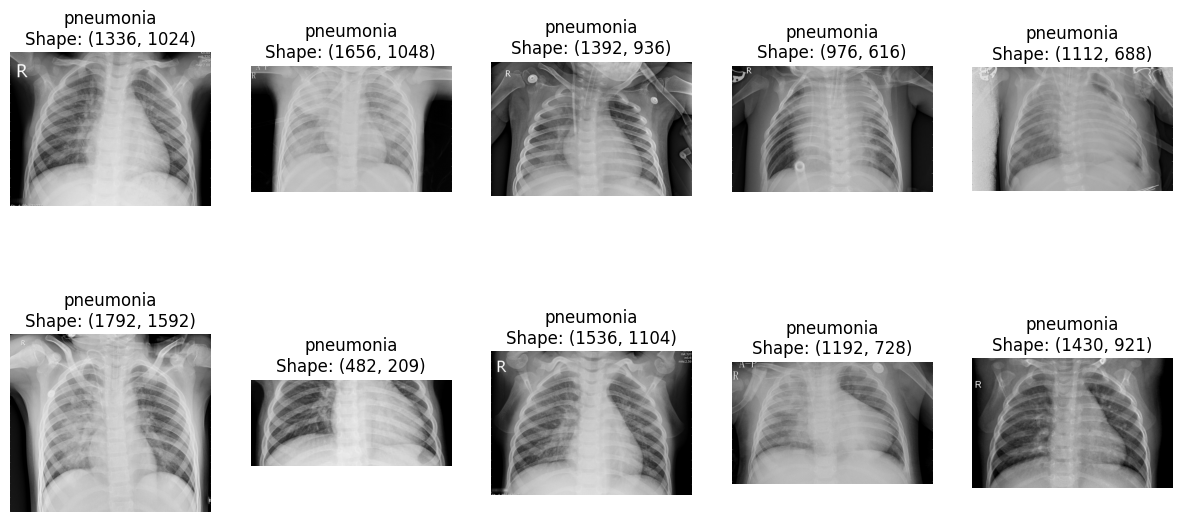

In [47]:
# Display sample pneumonia images using the plot_images function
plot_images(pneumonia_paths, 'pneumonia')

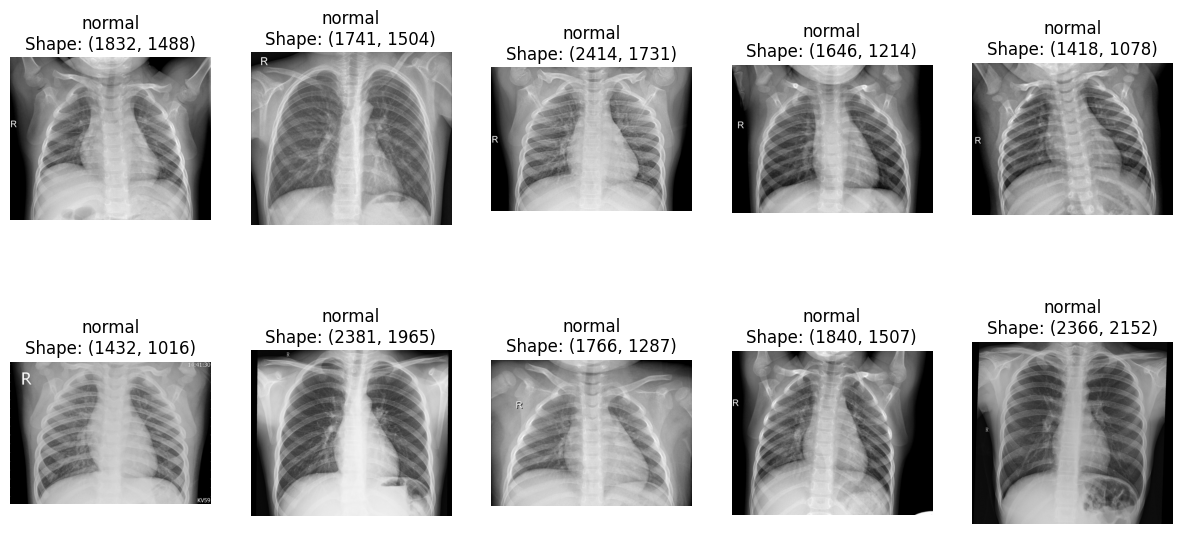

In [48]:
plot_images(normal_paths, 'normal')

In [49]:
# Filter training data to include only images smaller than 10 KB
filtered_pneumonia_path = train_df.query("label == 'pneumonia' and size_kb < 10")['file'].values
filtered_normal_path    = train_df.query("label == 'normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_path))
print(len(filtered_normal_path))


28
0


In [50]:
# Filter the test dataset to include only images smaller than 10 KB
filtered_pneumonia_test = test_df.query("label == 'pneumonia' and size_kb < 10")['file'].values
filtered_normal_test    = test_df.query("label == 'normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_test))
print(len(filtered_normal_test))


8
0


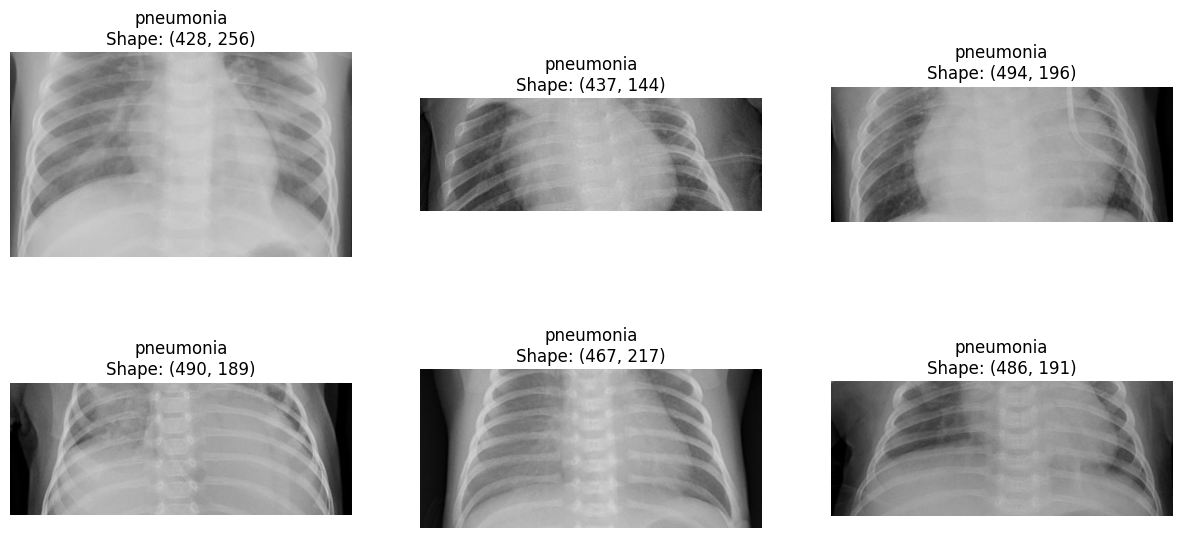

In [51]:
# Display a 2×3 grid of pneumonia images using the plot_images function
plot_images(filtered_pneumonia_path, 'pneumonia', nrows=2, ncols=3)


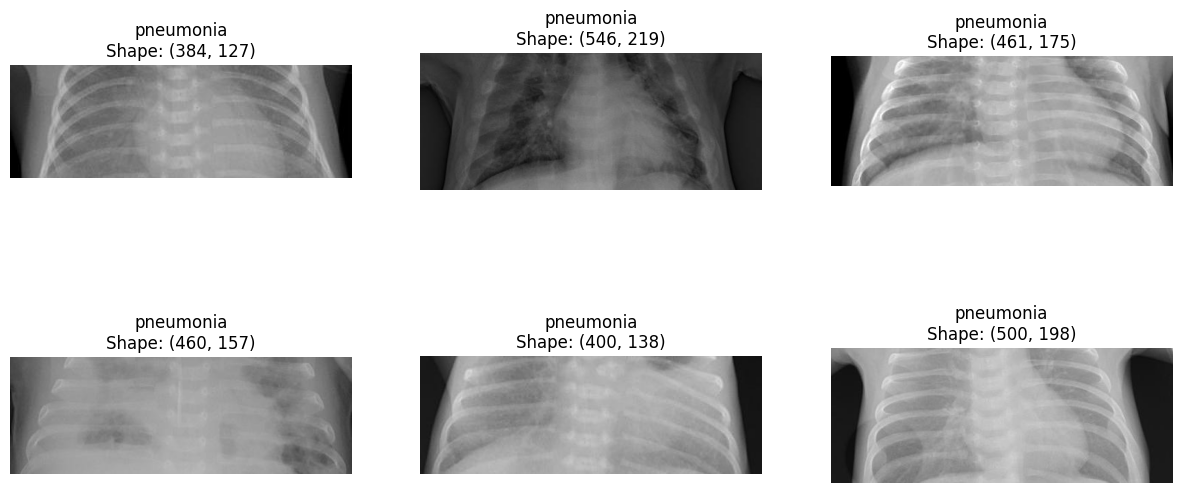

In [52]:
plot_images(filtered_pneumonia_test, 'pneumonia', nrows=2, ncols=3)

From the visualization results, several observations can be made:
    

*   Some images appear slightly tilted either to the left or right.
*   A number of images include visible hands or the patient’s chin.
*   Several images seem partially cropped, which is consistent with their file sizes being below 10 KB.
*   There are images that appear noticeably brighter or darker than others.


Based on these findings, the preprocessing stage will likely require data augmentation techniques such as random rotation, zoom adjustments, and potentially color jitter to improve robustness.



In [53]:
pneumonia_paths

array(['/content/pneumonia-Xray-dataset/chest_xray/test/PNEUMONIA/person1634_virus_2830.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person1735_bacteria_4570.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person1405_bacteria_3566.jpeg',
       ...,
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person489_bacteria_2065.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person933_virus_1594.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person531_bacteria_2237.jpeg'],
      dtype=object)

In [54]:
# Split the file path into its directory components using the system path separator
tf.strings.split('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg',
                 os.path.sep)


<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'', b'kaggle', b'input', b'chest-xray-pneumonia', b'chest_xray',
       b'train', b'PNEUMONIA', b'person1180_virus_2010.jpeg'],
      dtype=object)>

# Data Preprocessing

In [55]:
def preprocess_image(file_path, label, channels=3):
    # Read the image file
    img = tf.io.read_file(file_path)

    # Decode the JPEG image into a tensor
    img = tf.image.decode_jpeg(img, channels=channels)

    # Resize the image to match the model's input requirements
    img = tf.image.resize(img, [224, 224])

    # Normalize pixel values to the range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    # Convert labels to numeric format (0 = normal, 1 = pneumonia)
    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)

    return img, label


Next, we will examine the results of applying color jitter augmentation to determine whether it improves the model’s performance or potentially degrades it. Since color jitter operates on RGB images, we need to ensure that the input is processed with channels=3.

In [56]:
def color_jitter(image, brightness_factor=0.02, contrast_factor=0.02, seed=None):
    # Apply random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)

    # Apply random contrast adjustment
    image = tf.image.random_contrast(
        image,
        lower=1 - contrast_factor,
        upper=1 + contrast_factor,
        seed=seed
    )

    # Apply random saturation adjustment
    image = tf.image.random_saturation(
        image,
        lower=1 - contrast_factor,
        upper=1 + contrast_factor,
        seed=seed
    )

    # Apply random hue adjustment
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)

    return image


In [57]:
def visualize(original, augmented):
    # Create a side‑by‑side comparison of the original and augmented images
    fig = plt.figure()

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title("Augmented Image")
    plt.imshow(augmented)


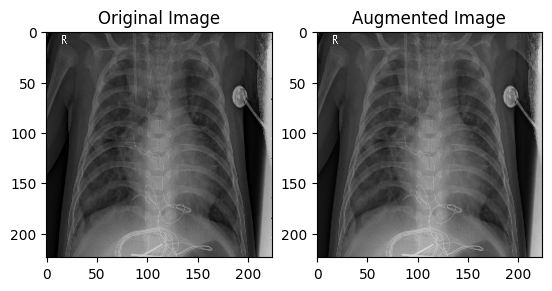

In [58]:
# Load an example pneumonia image and apply preprocessing
image_path = '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'
img, label = preprocess_image(image_path, 'pneumonia', channels=3)

# Apply color jitter augmentation for testing
color_jitter_test = color_jitter(img, seed=3)

# Visualize the original image alongside its augmented version
visualize(img, color_jitter_test)


In [59]:
img.shape

TensorShape([224, 224, 3])

In [60]:
number = train_df.shape[0]
factors = []

# Loop to identify all divisors of the value
for i in range(1, number + 1):
    if number % i == 0:
        factors.append(i)

# Print the list of divisors
print("The divisors of", number, "are:", factors)


The divisors of 4099 are: [1, 4099]


In [61]:
# Constant used to enable automatic performance optimization for the dataset pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Batch size used during model training
batch_size = 32


Notes:

*   **AUTOTUNE**:  A constant used to enable automatic performance optimization for the dataset pipeline. This allows TensorFlow to adjust configuration settings dynamically to maximize speed and efficiency during data processing.

*   **batch_size:** The number of samples processed together in a single training iteration. A batch size of 32 means that 32 data samples are fed into the model at once during each step of training. The chosen batch size can influence both training speed and memory usage.

In [62]:
# Augmentation function for training data
def augment_train_image(img, label):
    # Apply any required augmentation techniques
    # img = tf.image.random_flip_left_right(img)
    # img = tf.image.random_flip_up_down(img)
    img = color_jitter(img, seed=3)
    return img, label

# Augmentation function for validation data
def augment_val_image(img, label):
    # Apply augmentation if needed (typically minimal for validation)
    return img, label

# Additional augmentation layers applied through a Keras Sequential model
layers_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),
                               width_factor=(0.05, 0.1)),
])


In the layers_augmentation block, we apply Random Zoom and Random Rotation with relatively small values to ensure that the augmented images remain clear and that the model can still recognize the underlying visual patterns effectively.

In [63]:
def prepare(ds, batch_size=32, shuffle=False, layers_aug=False, custom_aug=False):
    # Apply the preprocess_image function to the dataset
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()

    # Shuffle the dataset if enabled
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply custom augmentation if requested
    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Apply augmentation layers if enabled
    if layers_aug:
        ds = ds.map(
            lambda x, y: (layers_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Batch and prefetch for optimized pipeline performance
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)

    return ds


**Explanation:**  
  
The function above is used to prepare the dataset using tf.data, enabling efficient preprocessing and parallelized training. This approach helps accelerate model training, especially when running on a GPU.

*   ds.cache(): Stores the dataset in cache to avoid re-reading the data from disk at the start of each epoch. This can significantly improve performance, although it may require substantial memory depending on the dataset size.
*   Shuffling (shuffle=True): When the shuffle parameter is set to True, the dataset is randomized. This prevents the model from memorizing the order of the samples and helps it learn more generalizable patterns.

*   ds.batch(batch_size): Groups the dataset into batches of the specified size. Batching is essential for efficient model training, as it enables batch‑based optimization and improves computational throughput.
*  ds.prefetch(AUTOTUNE): Uses prefetching to load the next batch while the current batch is being processed by the model. This improves the overlap between data preparation and model execution, leading to better CPU and GPU utilization.





In [64]:
# Create the training dataset using tf.data.Dataset.from_tensor_slices
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))

# Prepare the training dataset with preprocessing and custom augmentation
train_ds = prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)

# Create the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
val_ds = prepare(val_dataset, batch_size, shuffle=False)

# Create the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)
